In [12]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
import numpy as np
import matplotlib.pyplot as plt

## Pressure Potential 1D

In [13]:
def getFunction(x, a, b, c):
    return x, a*(1.+(x/b)**2)**(-c)
def getFunctionDeriv(x, a, b, c):
    return -(2*a*c*x*(1 + x^2/b^2)^(-1-c))/b^2
def getFTFunction(ks, a, b, c):
	import scipy.special
	#assumes profile in real space: a*(1+(x/b)^2)^(-c)
# 	print('PressureFourierTransTheoretical: assuming units(distance); cm')
	return ks, 2**(1.-c)*a/(b**2)**(-1./4.-c/2.)*abs(ks)**(-1./2.+c)*scipy.special.kv(1./2.-c, np.array(abs(ks)*abs(b)), dtype=np.complex)/scipy.special.gamma(np.complex(c))

$P(x)=a\left(1+\left(\frac{x}{b}\right)^2\right)^{-c} \\
P^\prime(x)=-\frac{2 a c x \left(1 + \left(\frac{x}{b}\right)^2\right)^{(-1 - c)}}{b^2} \\
\hat{P}(k)=\frac{2^{1-c}{a}{b^{2\left(\frac{1}{4}+\frac{c}{2}\right)}}|k|^{-\frac{1}{2}+c} K_v\left(\frac{1}{2}-c,k|b|\right)}{\Gamma(c)}$

In [14]:
functionReal = lambda x,p: getFunction(x, *p)
functionFourier = lambda x,p: getFTFunction(x, *p)

In [15]:
def doFFT(n=1000, n_pad=0, deltax=1, constants = [5e-10, 26., 0.67]):
    x1 = (-(n+n_pad)/2 + 1)*deltax;
#     deltax = x1/(-(n+n_pad)/2 + 1)
#     x1 = 0
#     grid = np.concatenate((np.arange(x1, x1+(n)*deltax, deltax),np.zeros((n_pad))))
#     grid = np.arange(x1, x1+(n+n_pad)*deltax, deltax)
    grid = np.arange(x1, x1+(n)*deltax, deltax)
    MaxX = np.max(grid)
    MaxX = grid[-1]-grid[0]
    spacing = deltax
#     print('Max value x direction', MaxX)
#     print('Spacing x values', MaxX)
#     print(constants)
    grid, samples = functionReal(grid, constants)
    samples = np.concatenate((samples,np.zeros(n_pad)))
    grid = np.arange(x1, x1+(n+n_pad)*deltax, deltax)
    factor = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n+n_pad))
#     print(np.sqrt(n/(2*np.pi))*deltax)
#     print(np.abs(factor))
    transform = np.fft.fft(samples, norm='ortho') * factor
    ks = np.fft.fftfreq(n+n_pad, d = deltax)*2*np.pi
    return ks, transform, MaxX, spacing, abs(functionFourier(ks,constants)[1]), constants, grid

/home/kristian/ArepoR/yt-conda/envs/py365SecTry/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


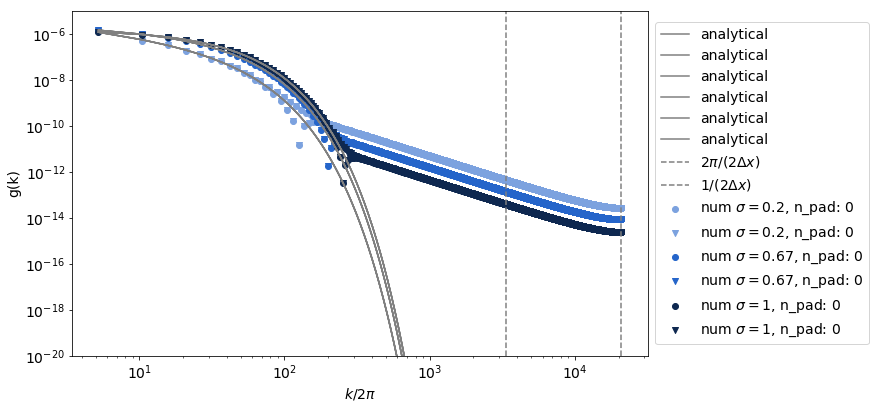

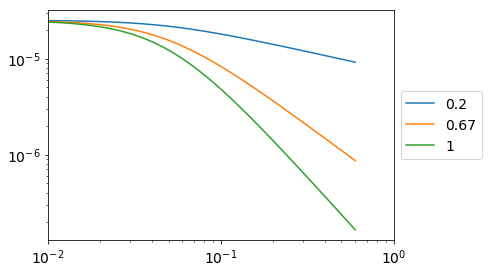

In [22]:
Colors = ['#7ca2df','#2565ca','#0e2850','#bb596d','#9F132F','#4f0917','#ffd27f','#FFA500','#664200']
Markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#sigma, mu, a, b
n = 8000
N_pad = [0,0]
deltax = 1.2 / n
fig = plt.figure(figsize=np.array([10,6]))
ax = plt.axes([0.15,0.15,0.8,.8])
a, b, c = 2.50330693e-05, 4.88035592e-02, 3.84470827e-01#5e-10, 26., 1
Nskip = 1
Constants = [[a, b, 0.2], [a, b, 0.67], [a, b, 1]]#, [a, b, 2]]
for constants,c in zip(Constants, Colors):
    for marker, n_pad in zip(Markers, N_pad):
        ks, transform, MaxX, spacing, anaFT, constants, grid = doFFT(n=n, n_pad=n_pad, deltax=deltax, constants = constants)
    #     ax.plot(2*np.pi/abs(ks), abs(anaFT), c='gray', label='analytical')
    #     ax.scatter(2*np.pi/np.array([ks,abs(transform)**1])[0],np.array([ks,abs(transform)**1])[1], label='num $\sigma=$%g' %(constants[0]))
        ax.plot(abs(ks)/(2*np.pi), abs(anaFT), c='gray', label='analytical')
        ax.scatter(*[x[::Nskip] if index == 1 else x[::Nskip]/(2*np.pi) for index,x in enumerate(np.array([ks,abs(transform)**1]))], c=c, marker=marker, label='num $\sigma=$%g, n_pad: %i' %(constants[-1], n_pad))

plt.axvline(x=2*np.pi/spacing/2, label=r'$2\pi/(2\Delta x)$', c='grey', ls='--')#can probe scales 2*dx
plt.axvline(x=1/spacing/2, label=r'$1/(2\Delta x)$', c='grey', ls='--')#can probe scales 2*dx
# plt.axvline(x=2*np.pi/spacing/8, label=r'$2\pi/(4\Delta x)$', c='grey', ls=':')#can probe scales 2*dx
# plt.axvline(x=0.5, label=r'pad ok', c='grey')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k/2\pi$')
ax.set_ylabel('g(k)')
# ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fig.canvas.draw()
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = ['%s'%(2*np.pi/float(l)) for l in labels if float(l)!=0]
# ax.set_xticklabels(labels)
ax.set_ylim([1e-20,1e-5])
plt.legend(loc='center left', framealpha=.8, fancybox=True, bbox_to_anchor=(1,0.5))

# fig.savefig('TestingFourierAnalyticsPressureProfileGXPython.pdf', dpi=450)


fig = plt.figure()
ax1 = plt.axes([0.15,0.15,0.8,.8])
# print(grid[grid>0])
for constants in Constants:
    ax1.plot(*functionReal(grid,constants), label='%g' %constants[-1])
ax1.set_xlim([1e-2,1e0])
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.legend(loc='center left', framealpha=.8, fancybox=True, bbox_to_anchor=(1,0.5))

plt.show()

## Include random fluctutations

In [6]:
def makeIterable(obj, number, name='name'):
    if not isinstance(obj, collections.Iterable):
        obj = [obj for i in range(number)]
    if np.size(obj)<number:
        print(name, obj)
        raise Exception('need more information for %sx, %sy, ...' %(name,name))
    return obj

In [7]:
def getFigure():
    fig = plt.figure()
    ax = plt.gca()
    return fig, ax

def modifyPlot(ax, xlog=False, ylog=False, xlabel='', ylabel=''):
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

In [8]:
import collections
import FigureMove as Fig
import auxiliary_functions as aux
import importlib
importlib.reload(aux)
importlib.reload(Fig)
def x1(n ,n_pad, delta):
    return (-(n+n_pad)/2 + 1)*delta

class FourierTransformObj:
    def __init__(self, spaceDim, fieldDim, n, delta, snap=None, sigma_to_be=1, kL=1/np.sqrt(3), kinj=40, kcrit=80, a=0, b=-11./3., c=0, n_pad=0, realFT=False):
        '''
        delta (list): seperation in real space between grid points
        spaceDim (int, list): number of dimensions of space
        fieldDim (int, list): number of dimensions of space
        '''
        self.spaceDim = spaceDim
        self.fieldDim = fieldDim
        self.n = makeIterable(n, self.spaceDim, 'n')
        self.n_pad = makeIterable(n_pad, self.spaceDim, 'n_pad')
        self.delta = makeIterable(delta, self.spaceDim, 'delta')
        self.sigma_to_be = sigma_to_be
        self.kL = kL
        self.kinj = kinj
        self.kcrit = kcrit
        self.a = a
        self.b = b
        self.c = c
        self.realFT = realFT
        self.statusField = None
        self.nofp = np.prod(self.n)
        self.ks = None
        self.ksNormed = None
        self.kabs = None
        self.xs = None
        self.xAbs = None
        self.factor = None
        
        self.snap = snap
        print('spetrum with parameters: kL=',kL,' kinj=',kinj,' kcrit=',kcrit,' a=',a,' b=',b, 'c=',c)
            
    def initializeKVectors(self, ignoreTwoPi=True):
        factor = 1.
        if not ignoreTwoPi:
            factor = 2.*np.pi
        if not self.realFT:
            self.ks = np.array(np.meshgrid(*(np.fft.fftfreq(self.n[i]+self.n_pad[i], d=self.delta[i])*factor for i in range(self.spaceDim))))
        else:
            self.ks = np.array(np.meshgrid(*(np.fft.rfftfreq(self.n[i]+self.n_pad[i], d = self.delta[i])*factor if i==0 else np.fft.fftfreq(self.n[i]+self.n_pad[i], d = self.delta[i])*factor for i in range(self.spaceDim))) )                                         
        self.kabs = np.sqrt(np.sum(self.ks**2 ,axis=0))

    def initializeXVectors(self):
        def x1(n ,n_pad, delta):
            return (-(n+n_pad)/2 + 1)*delta
        self.xs = np.array(np.meshgrid(*(np.arange(x1(self.n[i] ,self.n_pad[i], self.delta[i]), x1(self.n[i] ,self.n_pad[i], self.delta[i])+(self.n[i]+self.n_pad[i])*self.delta[i], self.delta[i]) for i in range(self.spaceDim))))
        self.xabs = np.sqrt(np.sum(self.xs**2, axis=0))
    
    def getTrafoFactor(self):
        if self.factor is not None:
            return
        if not self.realFT:
            factorGrid = np.meshgrid(*(np.arange(0, self.n[i]+self.n_pad[i]) for i in range(self.spaceDim)))
            self.factor = np.array([np.sqrt(self.n[i]/(2*np.pi))*self.delta[i]*np.exp(-2*np.pi*np.complex(0,1)*x1(self.n[i], self.n_pad[i], self.delta[i])/(self.n[i]*self.delta[i])*np.array(factorGrid[i], dtype=np.complex)) for i in range(self.spaceDim)])
            self.factor = np.prod(self.factor, axis=0)
        else:
            factorGrid = np.meshgrid(*(np.arange(0, (self.n[i]+self.n_pad[i])/2+1) if i==0 else np.arange(0, self.n[i]+self.n_pad[i]) for i in range(self.spaceDim)))
            self.factor = np.array([np.sqrt(self.n[i]/(2*np.pi))*self.delta[i]*np.exp(-2*np.pi*np.complex(0,1)*x1(self.n[i], self.n_pad[i], self.delta[i])/(self.n[i]*self.delta[i])*np.array(factorGrid[i], dtype=np.complex)) for i in range(self.spaceDim)])
            self.factor = np.prod(self.factor, axis=0)            
    
    def kspace(self, ignoreFactor=True, inplace=True):
        if self.statusField == 'kspace':
            print('already in kspace!')
            return self.field
        factor = 1.
        if not ignoreFactor:
            self.getTrafoFactor()
            factor = self.factor
        if self.realFT:
            transform = np.fft.rfftn(self.field, norm='ortho') * factor
        else:
            transform = np.fft.fftn(self.field, norm='ortho') * factor
        if inplace:
            self.field = transform
            self.statusField = 'kspace'
        return transform

    def rspace(self, ignoreFactor=True, inplace=True):
        if self.statusField == 'rspace':
            print('already in rspace!')
            return self.field
        factor = 1.
        if not ignoreFactor:
            self.getTrafoFactor()
            factor = self.factor
        if self.realFT:
            transform = np.fft.irfftn(self.field, norm='ortho') * 1/(factor)
        else:
            transform = np.fft.ifftn(self.field, norm='ortho') * 1/(factor)
        if inplace:
            self.field = transform
            self.statusField = 'rspace'
        return transform

    def initializeField1D(self):
        rand0 = np.zeros(tuple(self.n[i] for i in range(self.spaceDim)), dtype = np.complex)
        self.A = 1.
        self.B = self.A/(self.kinj**(self.b-self.a) * np.exp(-(self.kinj/self.kcrit)**self.c))
        sigma = np.sqrt(get_PowerSpec(self.kabs, self.kL, self.kinj, self.kcrit, self.A, self.B, self.a, self.b, self.c))/np.sqrt(2.)
        rand0.real, rand0.imag = self.random_gauss(sigma)
        self.A = self.sigma_to_be**2/np.sum(abs(rand0)**2)*self.nofp**2
        self.A = np.sqrt(self.A)
        self.B *= self.A
        return rand0*self.A
    
    def initializeFieldND(self):
        self.field = []
        for i in range(self.fieldDim):
            brand = self.initializeField1D()
            self.field.append(brand)
        self.statusField = 'kspace'

    def getSnapshotFieldND(self, variable, spaceDim=None, fieldDim=None, delta=None):
        self.variable = variable
        if spaceDim is not None:
            self.spaceDim = spaceDim
        if fieldDim is not None:
            self.fieldDim = fieldDim
        if variable not in self.snap.data.keys():
            self.snap.data[variable] = aux.get_value(variable, self.snap)
            if self.fieldDim is None:
                self.fieldDim = np.shape(self.snap.data[variable])[0]
        if n is not None:
            self.n = makeIterable(n, self.spaceDim, 'n')
        if n_pad is not None:
            self.n_pad = makeIterable(n_pad, self.spaceDim, 'n_pad')
        if delta is not None:
            self.delta = makeIterable(delta, self.spaceDim, 'delta')
        self.field = Fig.getAgrid(self.snap, variable, res=self.n, ProjBox=[nn*dd for nn,dd in zip(self.n, self.delta)], center=self.snap.center, numthreads=16)
        self.statusField = 'rspace'

    def random_gauss(self, sigma):
        np.random.seed(42)
        shape = np.shape(sigma)
        X1 = np.random.rand(*shape)
        X2 = np.random.rand(*shape)
        phi = 2.*np.pi*X1
        r = np.sqrt(-2*sigma**2*np.log(X2))
        return r*np.cos(phi), r*np.sin(phi)

    def cleanDivergence(self):
        self.kspace()
        if self.ksNormed is None:
            kabsInvert = np.nan_to_num(1./self.kabs)
            self.ksNormed = self.ks*kabsInvert
#         KdotB = np.sum(self.ksNormed*self.field, axis=0)
        self.field = self.field - self.ksNormed * np.sum(self.ksNormed*self.field, axis=0)
    
    def computeDivergence(self):
        field = self.kspace(inplace=False)
        if self.ksNormed is None:
            kabsInvert = np.nan_to_num(1./self.kabs)
            self.ksNormed = self.ks*kabsInvert
        return np.sum(np.abs(np.sum(field*self.ksNormed,axis=0))**2)/np.sum(np.abs(field)**2)
        
    def plotFT(self, comp=0, *args, **kwargs):
        field = self.kspace(inplace=False)
        if self.fieldDim > 1:
            field = field[comp]
        field = np.array(field).flatten()
        cords = np.array(self.kabs).flatten()
        self.plot(cords, field, *args, **kwargs)

    def plotIFT(self, *args, powerspec=False, binData=0, binLog=1, absolute=False, **kwargs):
        field = self.rspace(inplace=False)
        field = np.array(field).flatten()
        cords = np.array(self.xabs).flatten()
        self.plot(cords, field, *args, powerspec=powerspec, binData=binData, binLog=binLog, absolute=absolute, **kwargs)
    
    def plotTheoPS(self, *args, **kwargs):
        field = get_PowerSpec(self.kabs.flatten(), self.kL, self.kinj, self.kcrit, self.A**2, self.B*self.A, self.a, self.b, self.c)
        field = np.sqrt(np.array(field).flatten())
        cords = np.array(self.kabs).flatten()
        self.plot(cords, field, *args, **kwargs)
        
    def getAValue(self):
        print('compute A value with sigma_to_be', self.sigma_to_be, ' and nofp ', self.nofp)
        field = self.kspace(inplace=False)
        self.A = 1.
        self.B = self.A/(self.kinj**(self.b-self.a) * np.exp(-(self.kinj/self.kcrit)**self.c))
        self.A = self.sigma_to_be**2/np.sum(np.abs(field)**2)*self.nofp**2
        self.A = np.sqrt(self.A)
        self.B *= self.A
    
    def plot(self, x, y, absolute=True, ax=None, binData=True, NBins=100, binLog=True, powerspec=True, scatter=False, *args, **kwargs):
        if powerspec:
            absolute = True
        if ax is None:
            ax = plt.gca()
        if absolute:
            x = np.abs(x)
            y = np.abs(y)
        if binData:
            print('bin data: shapes x,y', np.shape(x), np.shape(y))
            x, y, err = Fig.do_Radprof(x, y, weight=None,range=[None,None],log=binLog,NBins=NBins,typeCalc='median',errbar=None, return_binedges=False, SameNumberPointsPerBin=False)
        if powerspec:
            y = y**2*x**2
        sort = np.argsort(x)
        x = x[sort]
        y = y[sort]
        if not scatter:
            ax.plot(x, y, *args, **kwargs)
        else:
            ax.scatter(x, y, *args, **kwargs)
def get_PowerSpec(k,kL,kinj,kcrit,A,B,a,b,c):
    print('powerspec:kL,kinj,kcrit,A,B,a,b,c',kL,kinj,kcrit,A,B,a,b,c)
    spec = np.zeros(np.shape(k))
    mask1 = k < kL
    mask2 = np.logical_and(k < kinj, k >= kL)
    mask3 = k >= kinj
    spec[mask1] = 0.
    spec[mask2] = A * k[mask2]**a
    spec[mask3] = B * k[mask3]**b * np.exp(-(k[mask3]/kcrit)**c)
    return spec


[100, 150] [0.5, 0.5, 0.5] [1.0, 1.0, 1.0]


## Import snapshot

In [9]:
folder = '/lustre/kristian/JetSims/PerseusCorrect/R6/E45/X5M1ASFCMy15IRe3E5V3E12/output/'
snap = Fig.quickImport(0, folder=folder)
print(snap.boxsize, snap.center)

folder,snapbase,time
/lustre/kristian/JetSims/PerseusCorrect/R6/E45/X5M1ASFCMy15IRe3E5V3E12/output/ snap_ 0
folder, time /lustre/kristian/JetSims/PerseusCorrect/R6/E45/X5M1ASFCMy15IRe3E5V3E12/output/ 0
/lustre/kristian/JetSims/PerseusCorrect/R6/E45/X5M1ASFCMy15IRe3E5V3E12/output//snap_000.hdf5
Found snap with time (code): 0
generalInfo time:
0.0 Myr
1.4925373134328357 [0.74626866 0.74626866 0.74626866]


In [10]:
0.1/np.min(snap.vol**(1/3))

285.3512577663358

spetrum with parameters: kL= 0.5773502691896258  kinj= 40  kcrit= 80  a= 0.0  b= -3.6666666666666665 c= 0.0
SqrtAbsoluteConstantMagneticFieldEnergyDensity
const B field: X_B=0.05
considering constant magnetic field with x_B=0.05 taking density/temperature from /ll1701/kristian/analysis/analyze_bubblepaper/IC_profile_Perseus_R_rho_u_codeunits.txt
using center of snapshot
------------- dist
[0.44701767 0.44848976 0.44650373 ... 0.46353865 0.46411562 0.46276814] dist
------------- dist
0.00024951977 0.8636755
assuming scaled position with h
(0.0003000341408988527, 0.000300029902990299)


/ll1701/kristian/analysis/analyze_bubblepaper/auxiliary_functions.py:429: UserWarning: dx cannot be larger than d_radius
  warnings.warn('dx cannot be larger than d_radius')


(0.0003000341408988527, 0.000300029902990299)
[0.74626866 0.74626866 0.74626866]
[400 400 400]
[0.1 0.1 0.1]
Selected 605581 of 70892985 particles.
already in kspace!
bin data: shapes x,y (64000000,) (64000000,)


/ll1701/kristian/analysis/analyze_bubblepaper/FigureMove.py:3771: UserWarning: setting MIN from 0 to 10 to use log
  warnings.warn('setting MIN from %g to %g to use log' %(minEarly,MIN))


statistics calcs took 15.9272


ValueError: not enough values to unpack (expected 3, got 2)

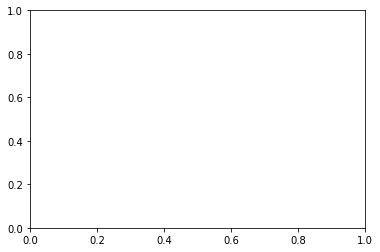

In [11]:
def getSnapField(spaceDim, fieldDim, n, delta, variable, **kwargs):#kL=1/np.sqrt(3), kinj=40, kcrit=80, a=0, b=-11./3., c=0):
    fourier = FourierTransformObj(spaceDim, fieldDim, n, delta, **kwargs)
    fourier.initializeKVectors()
    fourier.initializeXVectors()
    fourier.getSnapshotFieldND(variable)
    fourier.kspace()
    return fourier
s = np.sqrt(3.)
kL = 1/s #1/s
kinj = 40 #270#40#15 #8
kcrit = 80 #675#80 #20
a = 0.
b = -11./3.
c = 0.
spaceDim = 3
fieldDim = 1
n = 400
delta = 0.1 / n
n_pad = 0
realFT = False
variable = 'SqrtAbsoluteConstantMagneticFieldEnergyDensity'
# variable = 'SqrtMagneticFieldEnergyDensity'
# ------
fig, ax = getFigure()
magnetic = getSnapField(spaceDim, fieldDim, n, delta, variable, snap=snap, kL=kL, kinj=kinj, kcrit=kcrit, a=a, b=b, c=c, n_pad=n_pad, realFT=realFT)
magnetic.plotFT(marker='x', ax=ax, powerspec=True, label='ft')
# magnetic.getAValue()
# magnetic.plotTheoPS(ax=ax, powerspec=True, label='theory')
# print('div before clean', magnetic.computeDivergence())
# magnetic.cleanDivergence()
# print('div after clean', magnetic.computeDivergence())
# magnetic.plotFT(marker='x', ax=ax, label='div clean')
modifyPlot(ax, xlog=1, ylog=1, xlabel='k', ylabel=r'$k^2 {f_k}^2$')
# ax.legend()

In [ ]:
fig, ax = getFigure()

magnetic.plotFT(marker='x', ax=ax, powerspec=True, label='ft')
magnetic.getAValue()
# magnetic.plotTheoPS(ax=ax, powerspec=True, label='theory')
# print('div before clean', magnetic.computeDivergence())
# magnetic.cleanDivergence()
# print('div after clean', magnetic.computeDivergence())
# magnetic.plotFT(marker='x', ax=ax, label='div clean')
modifyPlot(ax, xlog=1, ylog=1, xlabel='k', ylabel=r'$k^2 {f_k}^2$')
# ax.legend()
plt.show()

In [ ]:
magnetic.kabs.max()/(2*np.pi)

In [ ]:
def getMagneticField(spaceDim, fieldDim, n, delta, **kwargs):#kL=1/np.sqrt(3), kinj=40, kcrit=80, a=0, b=-11./3., c=0):
    magnetic = FourierTransformObj(spaceDim, fieldDim, n, delta, **kwargs)
    magnetic.initializeKVectors()
    magnetic.initializeXVectors()
    magnetic.initializeFieldND()
    return magnetic

delta = 1.5 / n
s = np.sqrt(3.)
kL = 1/s #1/s
kinj = 40 #270#40#15 #8
kcrit = 80 #675#80 #20
a = 0.
b = -11./3.
c = 0.
spaceDim = fieldDim = 3
n = 200
n_pad = 0
realFT = False
# ------
fig, ax = getFigure()
magnetic = getMagneticField(spaceDim, fieldDim, n, delta, kL=kL, kinj=kinj, kcrit=kcrit, a=a, b=b, c=c, n_pad=n_pad, realFT=realFT)
magnetic.plotFT(marker='x', ax=ax, powerspec=True, label='ft')
# f = magnetic.field
# x, y, err = Fig.do_Radprof(x, y, weight=None,range=[None,None],log=binLog,NBins=NBins,typeCalc='median',errbar=None, return_binedges=False, SameNumberPointsPerBin=False)

# magnetic.rspace()
# magnetic.field.imag = 0
# print(magnetic.field)
# print(magnetic.realFT,'magnetic.realFT')
magnetic.plotFT(marker='o', ax=ax, powerspec=True, NBins=100, alpha=0.5, label='ft: back to real')
magnetic.plotTheoPS(ax=ax, powerspec=True, label='theory')
# print('div before clean', magnetic.computeDivergence())
# magnetic.cleanDivergence()
# print('div after clean', magnetic.computeDivergence())
# magnetic.plotFT(marker='x', ax=ax, label='div clean')
# magnetic.rspace()
# magnetic.plotFT(marker='x', ax=ax, label='div clean')

modifyPlot(ax, xlog=1, ylog=1, xlabel='k', ylabel=r'$k^2 {f_k}^2$')
ax.legend()
# ax.plot(magnetic.kabs, get_PowerSpec(magnetic.kabs,kL,kinj,kcrit,magnetic.A**2,magnetic.A*magnetic.B,a,b,c)*magnetic.kabs**2)
# ax.plot(magnetic.kabs, magnetic.kabs**(-5/3))
# ax = modifyPlot(ax, xlog=1, ylog=1, xlabel='k', ylabel=r'$k^2 {f_k}^2$')
# fig, ax = getFigure()
# magnetic.plotIFT(ax=ax, scatter=1)
# ax = modifyPlot(ax, xlog=0, ylog=0, xlabel='r', ylabel=r'$f(r)$')
# print('np.shape(magnetic.xs), np.shape(magnetic.xabs)', np.shape(magnetic.xs),np.shape(magnetic.xabs))
# print('divK',np.sum(np.abs(magnetic.field) * magnetic.kabs))
# magnetic.cleanDivergence()
# # print(np.sum(magnetic.ksNormed**2,axis=0))
# fig, ax = getFigure()
# magnetic.plotFT(marker='x',ax=ax)
# ax = modifyPlot(ax, xlog=1, ylog=1, xlabel='k', ylabel=r'$k^2 {f_k}^2$')
# ax.legend()
# # print('divK',np.sum(np.abs(magnetic.field) * magnetic.kabs))

In [ ]:
np.shape(magnetic.field),np.shape(magnetic.kabs)

In [ ]:
np.shape(magnetic.field)

In [ ]:
magnetic.rspace(inplace=False)